In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model, parse_simulated_data, get_data_filenames, add_sequence_columns
import interpretability.interp_helpers as interp

import utils.file_management as fm

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [58]:
run = 36

In [59]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# run = fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print number of parameters and important metadata
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Using cpu device
Total number of parameters: 292


In [60]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

events = parse_simulated_data(*get_data_filenames(run, suffix='v'))
events = add_sequence_columns(events, T)
vc = events[f'seq{T}_RL'].value_counts()
sequences = vc[vc > 100].sample(n=20).index

Raw weights: N dimensions for each token (fixed at 4 right now, single letter vocab) and T positions (sequence length)

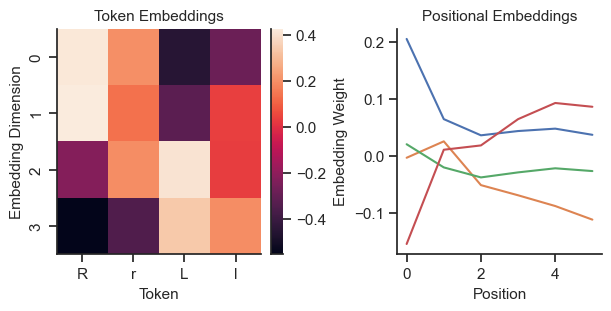

In [61]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 3), layout='constrained')
sns.heatmap(model.transformer.wte.weight.detach().cpu().numpy().T, ax=axs[0])
axs[0].set(title='Token Embeddings', xticklabels=vocab, xlabel='Token', ylabel='Embedding Dimension')
axs[1].plot(model.transformer.wpe.weight.detach().cpu().numpy())
axs[1].set(title='Positional Embeddings', xlabel='Position', ylabel='Embedding Weight')
sns.despine()


<Axes: >

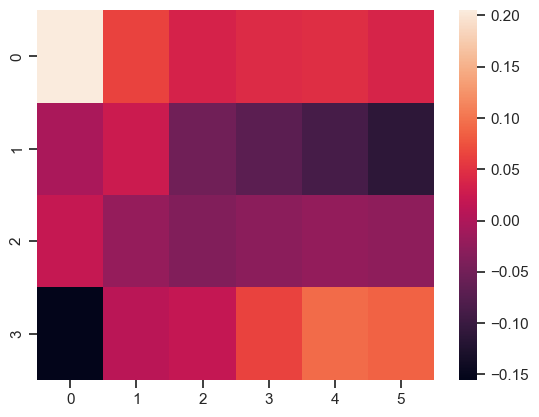

In [62]:
sns.heatmap(model.transformer.wpe.weight.detach().cpu().numpy().T)

### Starting by just looking at token embeddings
- What is the dimensionality of the token embeddings?
- Pairwise similarity between each of the token embeddings


Explained variance ratio: [9.2378461e-01 7.4650988e-02 1.5643967e-03 3.9824101e-17]
Cumulative explained variance: [0.9237846 0.9984356 1.        1.       ]


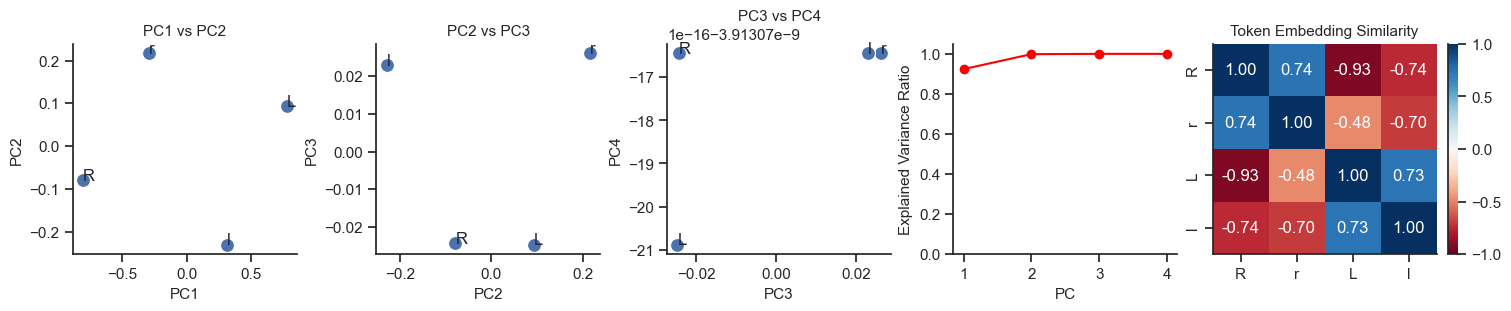

In [63]:
pca, embedded = interp.pca_embeddings(
    model, 
    n_components=4,
    token_mapping=stoi
)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

### Trajectory of learning this embedding space
Projecting token embeddings of each checkpoint into the embedding space (first 2 PCs) of the final trained model

Found 15 models for run 36


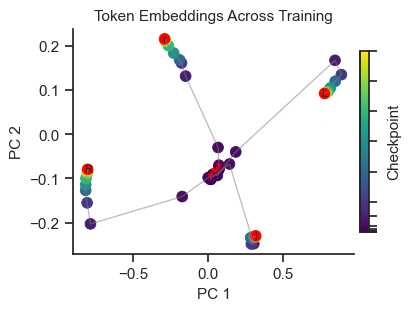

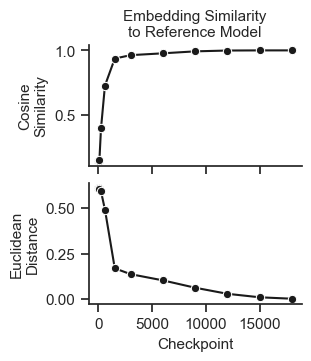

In [69]:
cp_data = interp.analyze_embedding_evolution(run)

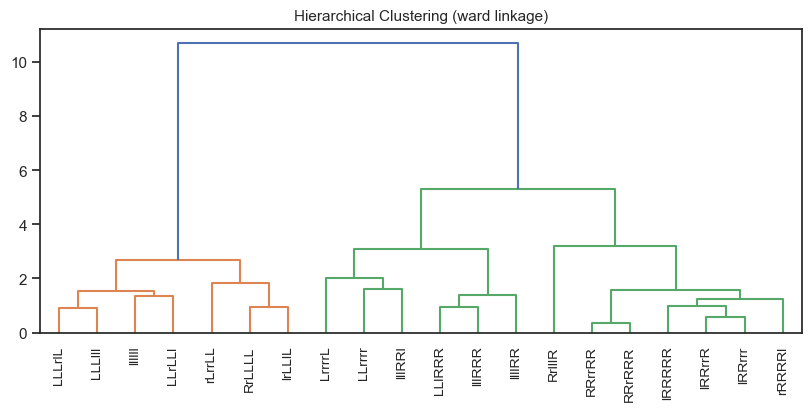

In [70]:
embeddings, similarities = interp.sequence_embedding_similarity(model, sequences, stoi)

ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, sequences, replot=False)

[Text(0.5, 1.0, 'run 36')]

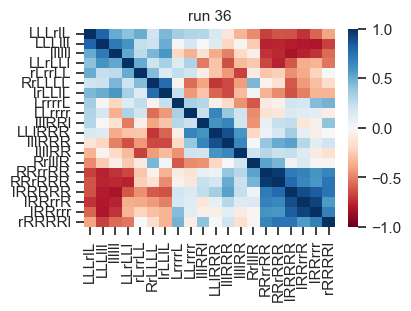

In [71]:
ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences)
ax.set(title=f'run {run}')

Using cpu device


Text(0.5, 0.98, 'Similarity Matrix (ordered by hierarchical clustering of first run)')

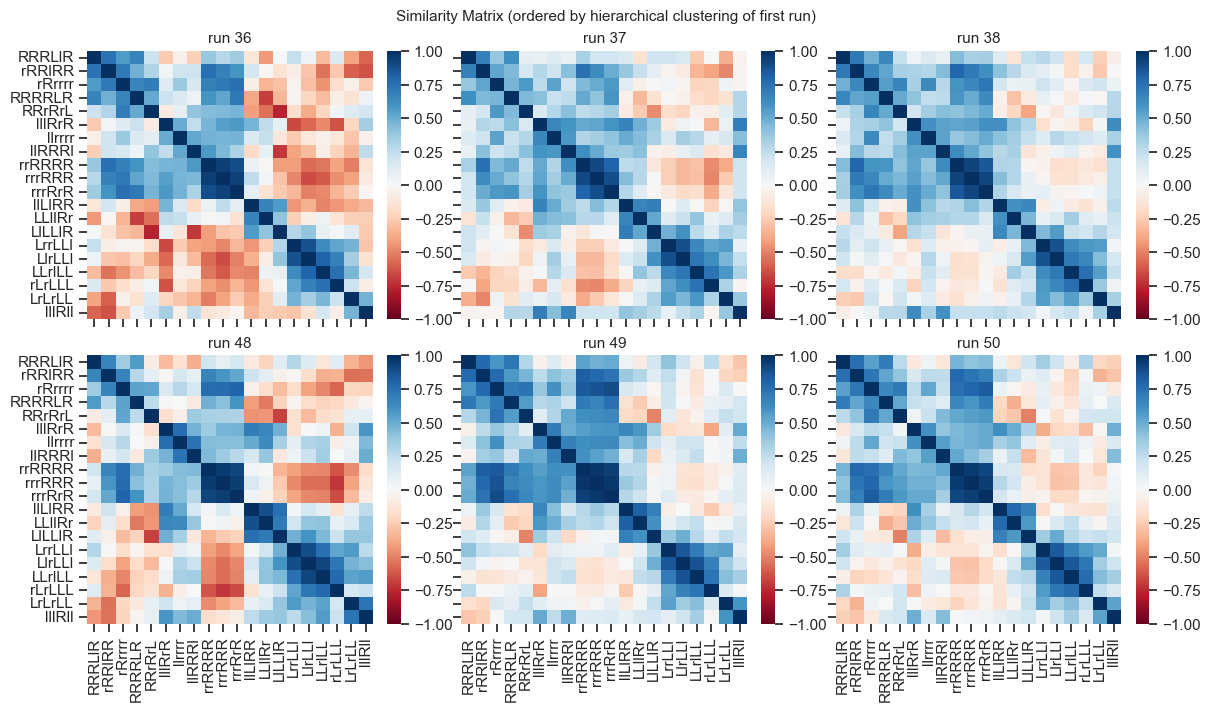

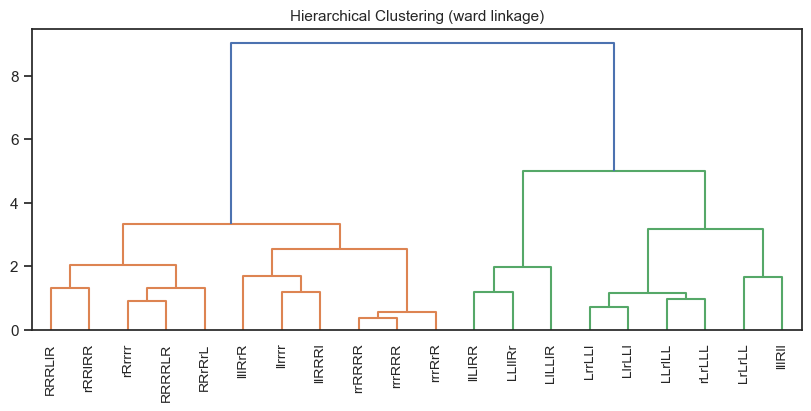

In [49]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = 6 # For now let's just look at fixed sequence length across models
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")


In [77]:
model_summary.query('run_number in @usable_runs')[['run_number', 'model_id', 'domain_id', 'n_embd']]

,run_number,model_id,domain_id,n_embd
0,36,l1_h1_e100_c6_d4,A,4
1,37,l1_h1_e100_c6_d8,A,8
2,38,l1_h1_e100_c6_d16,A,16
12,48,l1_h1_e100_c6_d4,B,4
13,49,l1_h1_e100_c6_d8,B,8
14,50,l1_h1_e100_c6_d16,B,16
24,61,l1_h1_e100_c6_d8,C,8
25,62,l1_h1_e100_c6_d16,C,16
26,60,l1_h1_e100_c6_d4,C,4


Text(0.5, 0.98, 'Similarity Matrix (ordered by hierarchical clustering of first run)')

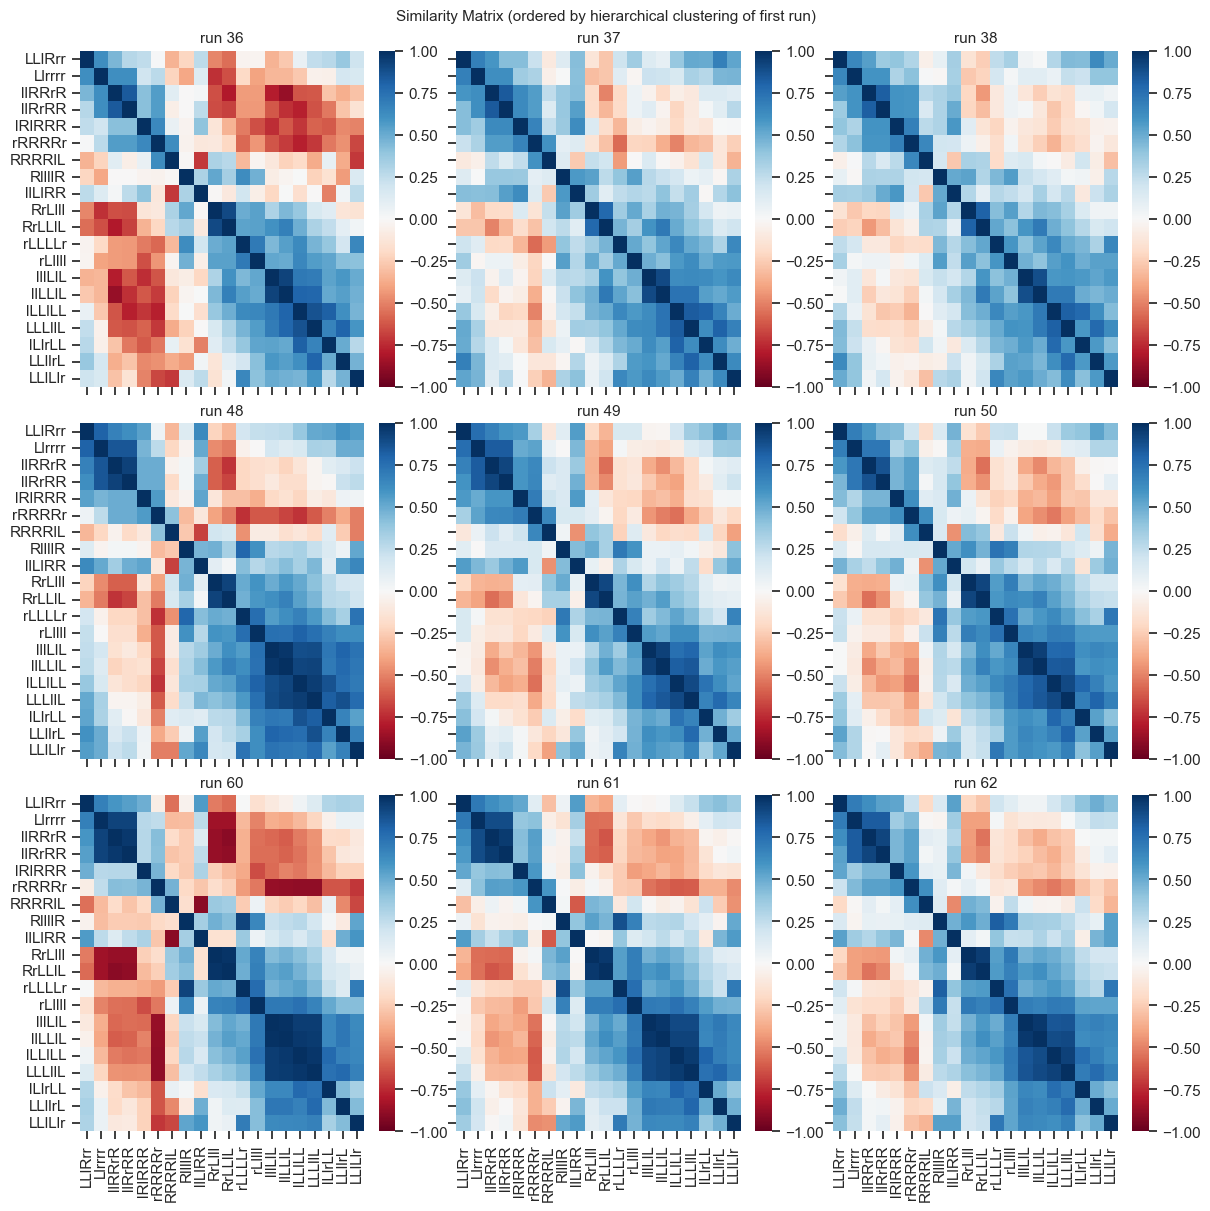

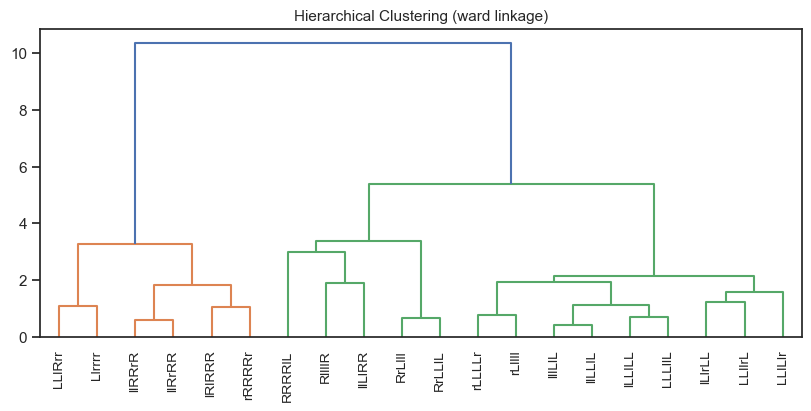

In [76]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12),
                        layout='constrained', sharex=True, sharey=True)

runs = [int(run.split('_')[1]) for run in os.listdir('../experiments') if run != '.DS_Store']

usable_runs = [36, 37, 38, 48, 49, 50, 60, 61, 62]
# usable_runs = []
if not usable_runs:
    for run in runs:
        model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)
        if T == model_info['dataloader']['Sequence length (T)']:
            usable_runs.append(run)
usable_runs = sorted(usable_runs)

for i, (run, ax) in enumerate(zip(usable_runs, axs.ravel())):

    model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

    assert T == model_info['dataloader']['Sequence length (T)'], f"Sequence length mismatch for run {run}"
    events = parse_simulated_data(*get_data_filenames(run, suffix='v'))
    events = add_sequence_columns(events, T)
    vc = events[f'seq{T}_RL'].value_counts()
    if i == 0:  # Use same sequences for all models
        sequences = vc[vc > 100].sample(n=20).index
        _, similarities = interp.sequence_embedding_similarity(model, sequences, stoi)
        ordered_sequences, ordered_sim_matrix, _ = interp.cluster_sequences_hierarchical(similarities, sequences, replot=False)
    else:
        _, ordered_sim_matrix = interp.sequence_embedding_similarity(model, ordered_sequences, stoi)

    ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
    ax.set(title=f'run {run}')

fig.suptitle('Similarity Matrix (ordered by hierarchical clustering of first run)')

In [ ]:
fig, ax = plt.subplots(figsize=(0.4 * len(ordered_sequences), 0.4 * len(ordered_sequences)),
                               layout='constrained')
ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
ax.set(title='Similarity Matrix (Ordered by Hierarchical Clustering)')

In [73]:
usecols = [
    'model_id', 'domain_id',
       'num_samples', 'num_parameters', 'max_steps', 'run_number',
       'sequence_length', 'n_embd', 'epochs',
       'best_val_full_loss', 'best_val_full_loss_step', 'best_val_choice_loss',
       'best_val_choice_loss_step', 'best_val_reward_loss',
       'best_val_reward_loss_step'
]

model_summary = pd.read_csv('../model_summary.csv', usecols=usecols)
model_summary.query('sequence_length == 6')

,model_id,domain_id,num_samples,num_parameters,max_steps,run_number,sequence_length,n_embd,epochs,best_val_full_loss,best_val_full_loss_step,best_val_choice_loss,best_val_choice_loss_step,best_val_reward_loss,best_val_reward_loss_step
0,l1_h1_e100_c6_d4,A,9M,292,19250,36,6,4,100,0.640235,19200,0.252721,960,0.545596,960
1,l1_h1_e100_c6_d8,A,9M,968,19250,37,6,8,100,0.634298,19200,0.240519,768,0.566623,768
2,l1_h1_e100_c6_d16,A,9M,3472,19200,38,6,16,100,0.633895,15744,0.244704,576,0.529386,576
6,l1_h1_e300_c6_d8,A,29M,968,57750,43,6,8,300,0.632390,57750,0.263057,577,0.590266,577
7,l1_h1_e300_c6_d4,A,29M,292,57750,42,6,4,300,0.633366,57750,0.268483,1154,0.511335,1154
8,l1_h1_e300_c6_d16,A,29M,3472,57600,44,6,16,300,0.631894,57024,0.242853,576,0.529450,576
12,l1_h1_e100_c6_d4,B,9M,292,19250,48,6,4,100,0.774689,19250,0.233191,1152,0.670781,19250
13,l1_h1_e100_c6_d8,B,9M,968,19250,49,6,8,100,0.768246,19250,0.232485,768,0.621704,768
14,l1_h1_e100_c6_d16,B,9M,3472,19200,50,6,16,100,0.768931,19200,0.227304,384,0.664197,576
18,l1_h1_e300_c6_d4,B,29M,292,57600,54,6,4,300,0.769775,57600,0.242313,1152,0.668033,14976
